# **Libraries**

In [1]:
import os
from os.path import exists
import keras.models
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
import matplotlib.pyplot as plt
from keras.models import Sequential , Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization,GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/data.zip


# **Data Augmentation**

In [4]:
img_size = 224
batch_size = 32

input_path = '/content/data/'


# Data generation objects
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
test_val_datagen = ImageDataGenerator(rescale=1./255)

# This is fed to the network in the specified batch sizes and image size
train_gen = train_datagen.flow_from_directory(
directory=input_path+'train',
target_size=(img_size, img_size),
batch_size=batch_size,
class_mode='categorical',
shuffle=True)

test_gen = test_val_datagen.flow_from_directory(
directory=input_path+'test',
target_size=(img_size, img_size),
batch_size=batch_size,
class_mode='categorical',
shuffle=False)


Train_labels = train_gen.classes[train_gen.index_array]
Test_labels = test_gen.classes[test_gen.index_array]

classes = list(train_gen.class_indices.keys())
print('Classes: '+str(classes))

Found 6326 images belonging to 4 classes.
Found 771 images belonging to 4 classes.
Classes: ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']


In [5]:
# Distribution of our datasets
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    n_infect1 = len(os.listdir(input_path + _set + '/COVID19'))
    n_infect2 = len(os.listdir(input_path + _set + '/TURBERCULOSIS'))
    print('Set: {}, normal images: {}, pneumonia images: {},covid images: {},TB images: {}'.format(_set, n_normal, n_infect,n_infect1,n_infect2))

Set: train, normal images: 1341, pneumonia images: 3875,covid images: 460,TB images: 650
Set: val, normal images: 8, pneumonia images: 8,covid images: 10,TB images: 12
Set: test, normal images: 234, pneumonia images: 390,covid images: 106,TB images: 41


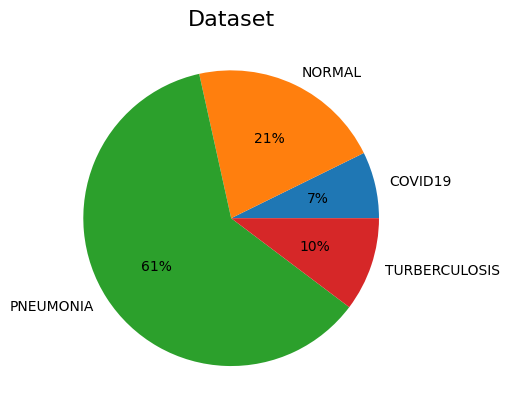

In [6]:
frequency = np.unique(train_gen.classes, return_counts=True)

plt.title("Dataset", fontsize='16')
plt.pie(frequency[1], labels = classes, autopct='%1.0f%%');


# **VGG16 Model**

**Here we have defined a function and have implemented the VGG16 architecture using Keras framework. We have performed some changes in the dense layer. In our model, we have replaced it with our own three dense layers of dimension 256×128 with ReLU activation and finally 1 with sigmoid activation.**

In [7]:
def VGG16():

    model = Sequential()

    #Block 1
    model.add(Conv2D(input_shape=(img_size,img_size,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

    #Block 2
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

    #Block 3
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

    #Block 4
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

    #Block 5
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),name='vgg16'))

    #Top layers
    model.add(Flatten(name='flatten'))
    model.add(Dense(256, activation='relu', name='fc1'))
    model.add(Dense(128, activation='relu', name='fc2'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax', name='output'))
    return model

model=VGG16()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

**we will use Transfer Learning for implementing VGG16 with Keras. So we will reuse the model weights from pre-trained models that were developed for standard computer vision benchmark datasets like ImageNet. We have downloaded pre-trained weights that do not have top layers weights. As you see above we have replaced the last three layers by our own layer and pre-trained weights do not contain the weights of newly three dense layers.**

In [8]:
# Grouping model layers into an object
Vgg16 = Model(inputs=model.input, outputs=model.get_layer('vgg16').output)

#load pretrained weights
Vgg16.load_weights("/content/drive/My Drive/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5")

In [9]:
# Freezing all convolutional block of vgg16
for layer in Vgg16.layers:
    layer.trainable = False

In [10]:
for layer in model.layers:
    print(layer, layer.trainable)

<keras.layers.convolutional.conv2d.Conv2D object at 0x7f656dd3ab90> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f656dd3b5b0> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f656dd3bbb0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f656dd39e70> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f656dd3b220> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f656c38f280> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f66052526b0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f656dd38e20> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f656dd3b550> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f66052535b0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f656c2ce0b0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f656e237010> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f656e237190> False
<keras.layers.poo

In [11]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [12]:
#create Checkpoint
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath ='best_weights16.hdf5', monitor='val_loss',save_best_only = True, verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode = 'min' , patience=10)
#Save and load model
if (os.path.exists('/content/drive/MyDrive/vgg_16.h5')):
   vgg16_model = tf.keras.models.load_model('/content/drive/MyDrive/vgg_16.h5')
else:
  history_vgg = model.fit(train_gen, validation_data=test_gen, epochs=12, callbacks= [cp_callback, es_callback])
  #Save Model
  file_path = '/content/drive/MyDrive/vgg_16.h5'
  tf.keras.models.save_model(model,file_path)






In [ ]:
# Plotting the training and validation accuracy
plt.plot(history_vgg.history['accuracy'])
plt.plot(history_vgg.history['val_accuracy'])
plt.title('VGG16 Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting the training and validation loss
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])
plt.title('VGG16 Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [13]:
#evaluation
val_accuracy_VGG16 = vgg16_model.evaluate(test_gen)
print(f"Test Accuracy: {val_accuracy_VGG16[1] * 100:.2f}%")

25/25 [==============================] - 572s 22s/step - loss: 0.3199 - accuracy: 0.9053
Test Accuracy: 90.53%


In [14]:
import itertools
#Gera matriz de confusão
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<ipython-input-15-31de9bab3fb8>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = vgg16_model.predict_generator(test_gen , workers=0)


Classification Report of VGG16
               precision    recall  f1-score   support

      COVID19       0.97      0.93      0.95       106
       NORMAL       0.91      0.79      0.85       234
    PNEUMONIA       0.91      0.95      0.93       390
TURBERCULOSIS       0.73      1.00      0.85        41

     accuracy                           0.91       771
    macro avg       0.88      0.92      0.89       771
 weighted avg       0.91      0.91      0.90       771



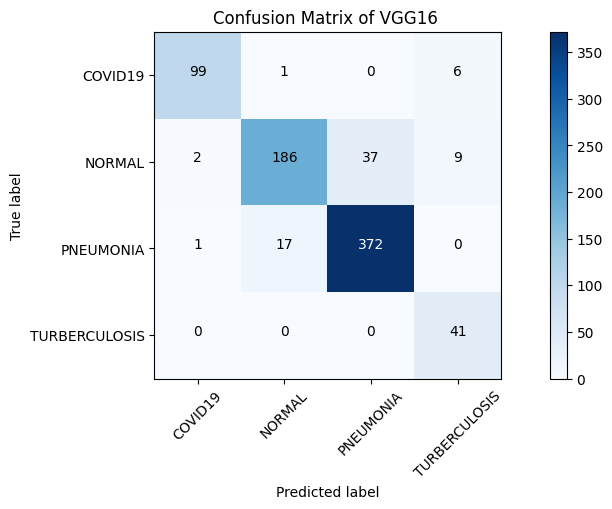

In [15]:
#Confution Matrix and Classification Report
Y_pred = vgg16_model.predict_generator(test_gen , workers=0)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix of VGG16 ')
print('Classification Report of VGG16')
print(classification_report(test_gen.classes, y_pred, target_names=target_names))

# **ResNet50V2**

**The ResNet50 architecture introduces residual connections, allowing for the training of very deep networks. It has 50 convolutional layers and employs skip connections to address the vanishing gradient problem. ResNet50 has achieved state-of-the-art performance on various image classification tasks**.


In [ ]:
def RESNET():
    res_model = tf.keras.applications.ResNet50V2(
        weights='imagenet',
        include_top = False,
        input_shape = (224,224,3),
        pooling = 'avg'
    )

    for layer in res_model.layers:
        layer.trainable=False

    x = res_model.output
    x = tf.keras.layers.Dense(128,activation='relu')(x)
    # output layer
    output = tf.keras.layers.Dense(4,activation='softmax')(x)

    res_model = tf.keras.Model(inputs = res_model.input, outputs = output)

    # Compiling the model
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    res_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    return res_model

res_model = RESNET()
res_model.summary()

In [17]:
#create Checkpoint
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath ='/content/drive/MyDrive/res_weights.hdf5',save_best_only = True, save_weights_only= False, verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode = 'max' , patience=4)
#Save and load model
if (os.path.exists('/content/drive/MyDrive/resnet.h5')):
   resnet_model = tf.keras.models.load_model('/content/drive/MyDrive/resnet.h5')
else:
  history_res = res_model.fit(train_gen, validation_data=test_gen, epochs=12, callbacks= [cp_callback, es_callback])
  #Save Model
  file_path = '/content/drive/MyDrive/resnet.h5'
  tf.keras.models.save_model(res_model,file_path)



In [19]:
#evaluation
val_accuracy_ResNet50 = resnet_model.evaluate(test_gen)
print(f"Test Accuracy: {val_accuracy_ResNet50[1] * 100:.2f}%")

25/25 [==============================] - 145s 6s/step - loss: 0.3379 - accuracy: 0.8833
Test Accuracy: 88.33%


In [ ]:
# Plotting the training and validation accuracy
plt.plot(history_res.history['accuracy'])
plt.plot(history_res.history['val_accuracy'])
plt.title('ResNet Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting the training and validation loss
plt.plot(history_res.history['loss'])
plt.plot(history_res.history['val_loss'])
plt.title('ResNet Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [20]:
import itertools
#Gera matriz de confusão
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<ipython-input-21-ea70c48e7b5f>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = resnet_model.predict_generator(test_gen , workers=0)


Classification Report of ResNet
               precision    recall  f1-score   support

      COVID19       1.00      0.74      0.85       106
       NORMAL       0.94      0.78      0.85       234
    PNEUMONIA       0.84      0.98      0.91       390
TURBERCULOSIS       0.85      0.95      0.90        41

     accuracy                           0.88       771
    macro avg       0.91      0.86      0.88       771
 weighted avg       0.89      0.88      0.88       771



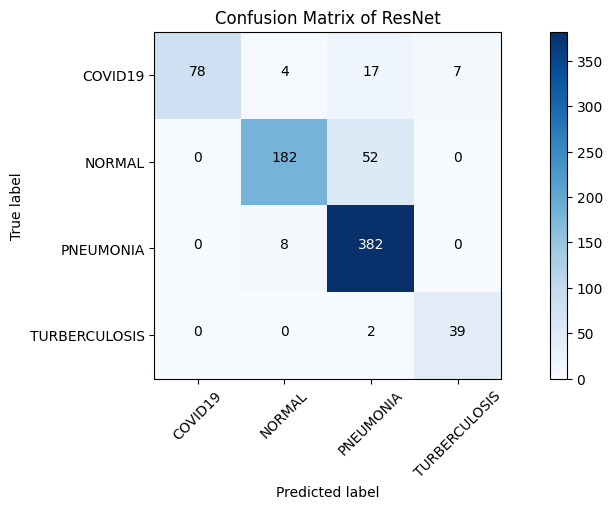

In [21]:
#Confution Matrix and Classification Report
Y_pred = resnet_model.predict_generator(test_gen , workers=0)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix of ResNet')
print('Classification Report of ResNet')
print(classification_report(test_gen.classes, y_pred, target_names=target_names))

# **DenseNet121**

 **DenseNet architecture introduces dense connections, where each layer is connected to every other layer in a feed-forward manner. Dense connections facilitate feature reuse, promote gradient flow, and alleviate the vanishing gradient problem. DenseNet has achieved competitive results on image classification tasks and is known for its parameter efficiency**.


In [ ]:
def DENSENET():
    dense_model = tf.keras.applications.DenseNet121(
        weights='imagenet',
        include_top = False,
        input_shape = (224,224,3),
    )

    for layer in dense_model.layers:
        layer.trainable=False

    x = dense_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128,activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    # output layer
    output = tf.keras.layers.Dense(4,activation='softmax')(x)

    dense_model = tf.keras.Model(inputs = dense_model.input, outputs = output)

    # Compiling the model
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    dense_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    return dense_model

dense_model = DENSENET()
dense_model.summary()

In [31]:
#create Checkpoint
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath ='/content/drive/MyDrive/dense_weights.hdf5',save_best_only = True, verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode = 'max' , patience=4)
#Save and load model
if (os.path.exists('/content/drive/MyDrive/dense_weights.hdf5')):
   densenet= tf.keras.models.load_model('/content/drive/MyDrive/dense_weights.hdf5')
else:
  history_dense = dense_model.fit(train_gen, validation_data=test_gen, epochs=7, callbacks= [cp_callback, es_callback])



In [ ]:
# Plotting the training and validation accuracy
plt.plot(history_dense.history['accuracy'])
plt.plot(history_dense.history['val_accuracy'])
plt.title('DenseNet Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting the training and validation loss
plt.plot(history_dense.history['loss'])
plt.plot(history_dense.history['val_loss'])
plt.title('DenseNet Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [32]:
#evaluation
val_accuracy_DenseNet = densenet.evaluate(test_gen)
print(f"Test Accuracy: {val_accuracy_DenseNet[1] * 100:.2f}%")

25/25 [==============================] - 153s 6s/step - loss: 0.3041 - accuracy: 0.8988
Test Accuracy: 89.88%


In [33]:
import itertools
#Gera matriz de confusão
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<ipython-input-34-bfba05d27e46>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = densenet.predict_generator(test_gen , workers=0)


Classification Report of DenseNet
               precision    recall  f1-score   support

      COVID19       0.98      0.83      0.90       106
       NORMAL       0.93      0.80      0.86       234
    PNEUMONIA       0.90      0.96      0.93       390
TURBERCULOSIS       0.71      1.00      0.83        41

     accuracy                           0.90       771
    macro avg       0.88      0.90      0.88       771
 weighted avg       0.91      0.90      0.90       771



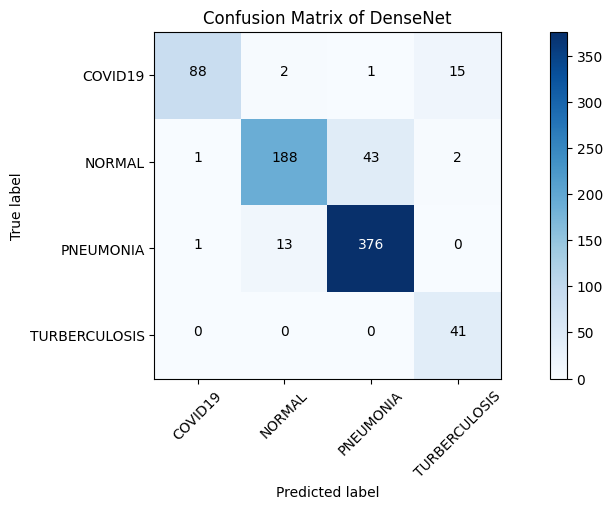

In [34]:
#Confution Matrix and Classification Report
Y_pred = densenet.predict_generator(test_gen , workers=0)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix of DenseNet')
print('Classification Report of DenseNet')
print(classification_report(test_gen.classes, y_pred, target_names=target_names))

# **MobileNetV2**

In [ ]:
def MOBILENET():
    mobile_model = tf.keras.applications.MobileNetV2(
        weights='imagenet',
        include_top = False,
        input_shape = (224,224,3),
    )

    for layer in mobile_model.layers:
        layer.trainable=False

    x = mobile_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128,activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    # output layer
    output = tf.keras.layers.Dense(4,activation='softmax')(x)

    mobile_model = tf.keras.Model(inputs = mobile_model.input, outputs = output)

    # Compiling the model
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    mobile_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    return dense_model

mobile_model = MOBILENET()
mobile_model.summary()


In [43]:
#create Checkpoint
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath ='/content/drive/MyDrive/mobile_weights.hdf5',save_best_only = True, save_weights_only= False, verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode = 'max' , patience=4)
#Save and load model
if (os.path.exists('/content/drive/MyDrive/mobile_weights.hdf5')):
   mobilenet= tf.keras.models.load_model('/content/drive/MyDrive/mobile_weights.hdf5')
else:
  history_mob = mobile_model.fit(train_gen, validation_data=test_gen, epochs=7, callbacks= [cp_callback, es_callback])




In [44]:
#evaluation
val_accuracy_MobileNet = mobilenet.evaluate(test_gen)
print(f"Test Accuracy: {val_accuracy_MobileNet[1] * 100:.2f}%")

25/25 [==============================] - 157s 6s/step - loss: 0.2559 - accuracy: 0.9079
Test Accuracy: 90.79%


In [ ]:
# Plotting the training and validation accuracy
plt.plot(history_mob.history['accuracy'])
plt.plot(history_mob.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting the training and validation loss
plt.plot(history_mob.history['loss'])
plt.plot(history_mob.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [40]:
import itertools
#Gera matriz de confusão
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<ipython-input-41-ed50ff699695>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = mobilenet.predict_generator(test_gen , workers=0)


Classification Report of MobileNetV2
               precision    recall  f1-score   support

      COVID19       0.99      0.87      0.92       106
       NORMAL       0.86      0.88      0.87       234
    PNEUMONIA       0.91      0.93      0.92       390
TURBERCULOSIS       0.95      0.95      0.95        41

     accuracy                           0.91       771
    macro avg       0.93      0.91      0.92       771
 weighted avg       0.91      0.91      0.91       771



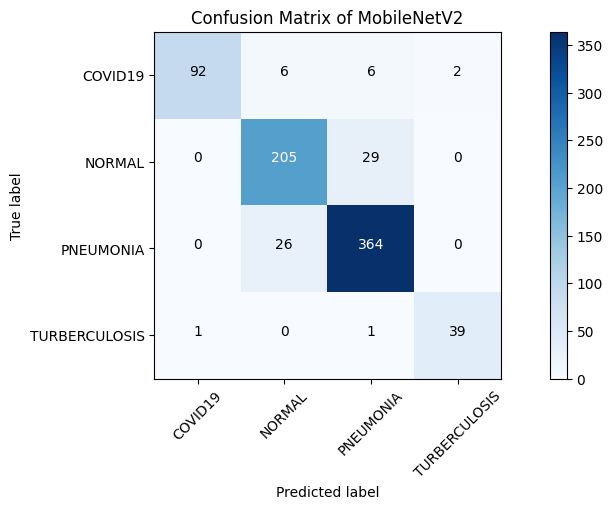

In [41]:
#Confution Matrix and Classification Report
Y_pred = mobilenet.predict_generator(test_gen , workers=0)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix of MobileNetV2')
print('Classification Report of MobileNetV2')
print(classification_report(test_gen.classes, y_pred, target_names=target_names))